In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

print("Modules loaded successfully")
print(f"TensorFlow version: {tf.__version__}")

data_path = "/Users/praneetgogoi/Documents/brain-mri-model/brain-mri/train"

image_paths = []
labels_list = []

for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path,class_name)
    if not os.path.isdir(class_path):
        continue

    for img_file in os.listdir(class_path):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_path, img_file))
            labels_list.append(class_name)

df = pd.DataFrame({'image_path': image_paths,'label': labels_list})
print(f"Total Images: {len(df)}")
print(f"Number of Classes: {df['label'].nunique()}")
print("\nClass Distribution:")
class_dist = df['label'].value_counts()
print(class_dist)

Modules loaded successfully
TensorFlow version: 2.20.0
Total Images: 1400
Number of Classes: 5

Class Distribution:
label
fukuyama_muscular_dystrophy         280
pachygyria_cerebellar_hypoplasia    280
walker_warburg_syndrome             280
moyamoya_disease                    280
hallervorden_spatz_disease          280
Name: count, dtype: int64


In [3]:

from sklearn.model_selection import train_test_split

strat = df['label']
train_df, temp_df = train_test_split(
    df, 
    train_size=0.8, 
    shuffle=True, 
    random_state=42, 
    stratify=strat
)

strat = temp_df['label']
val_df, test_df = train_test_split(
    temp_df, 
    train_size=0.5, 
    shuffle=True, 
    random_state=42, 
    stratify=strat
)

print(f"\nTraining Set: {train_df.shape[0]} images")
print(f"Validation Set: {val_df.shape[0]} images")
print(f"Test Set: {test_df.shape[0]} images")


Training Set: 1120 images
Validation Set: 140 images
Test Set: 140 images


In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)

print(f"\nNumber of classes: {num_classes}")
print(f"Class names: {class_names}")

Found 1120 validated image filenames belonging to 5 classes.
Found 140 validated image filenames belonging to 5 classes.
Found 140 validated image filenames belonging to 5 classes.

Number of classes: 5
Class names: ['fukuyama_muscular_dystrophy', 'hallervorden_spatz_disease', 'moyamoya_disease', 'pachygyria_cerebellar_hypoplasia', 'walker_warburg_syndrome']


In [5]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = True

for layer in base_model.layers[:100]: 
    layer.trainable = False
for layer in base_model.layers[100:]: 
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nModel Summary:")
model.summary()


Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,811,909 (94.65 MB)

 Trainable params: 20,672,005 (78.86 MB)

 Non-trainable params: 4,139,904 (15.79 MB)

In [6]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_resnet50_tf_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

print("\n" + "="*50)
print("Training ResNet50 Model...")
print("="*50)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)



Training ResNet50 Model...
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2471 - loss: 1.7390

35/35 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.2902 - loss: 1.6577 - val_accuracy: 0.2000 - val_loss: 1.6334 - learning_rate: 1.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3549 - loss: 1.5129

35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.3679 - loss: 1.4842 - val_accuracy: 0.2357 - val_loss: 1.5707 - learning_rate: 1.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4005 - loss: 1.4313

35/35 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.4134 - loss: 1.3921 - val_accuracy: 0.3571 - val_loss: 1.4511 - learning_rate: 1.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4976 - loss: 1.2618

35/35 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.4848 - loss: 1.2421 - val_accuracy: 0.4429 - val_loss: 1.2525 - learning_rate: 1.0000e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5342 - loss: 1.1278

35/35 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5134 - loss: 1.1798 - val_accuracy: 0.5214 - val_loss: 1.1599 - learning_rate: 1.0000e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5462 - loss: 1.1119

35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.5536 - loss: 1.0851 - val_accuracy: 0.5929 - val_loss: 1.0751 - learning_rate: 1.0000e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6138 - loss: 0.9919

35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6196 - loss: 0.9998 - val_accuracy: 0.6500 - val_loss: 0.9323 - learning_rate: 1.0000e-04
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6677 - loss: 0.9330

35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6741 - loss: 0.9054 - val_accuracy: 0.7071 - val_loss: 0.8209 - learning_rate: 1.0000e-04
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.6857 - loss: 0.8251 - val_accuracy: 0.6429 - val_loss: 0.9281 - learning_rate: 1.0000e-04
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7268 - loss: 0.7547 - val_accuracy: 0.5214 - val_loss: 1.3295 - learning_rate: 1.0000e-04
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7411 - loss: 0.7354 - val_accuracy: 0.6143 - val_loss: 1.3121 - learning_rate: 1.0000e-04
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7580 - loss: 0.6511 - val_accuracy: 0.6357 - val_loss: 1.0304 - learning_rate: 1.0000e-04
Epoch 13/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7794 - loss: 0.6385
Epoch 13: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7893 - loss: 0.6106 - val_accuracy: 0.7143 - val_loss: 0.9636 - learning_rate: 1.0000e-04
Epoch 14/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7976 - loss: 0.5694

35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8107 - loss: 0.5456 - val_accuracy: 0.7929 - val_loss: 0.6667 - learning_rate: 5.0000e-05
Epoch 15/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8428 - loss: 0.4752

35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8196 - loss: 0.5292 - val_accuracy: 0.8071 - val_loss: 0.5653 - learning_rate: 5.0000e-05
Epoch 16/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8402 - loss: 0.4403 - val_accuracy: 0.7429 - val_loss: 0.7668 - learning_rate: 5.0000e-05
Epoch 17/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8504 - loss: 0.4144

35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8455 - loss: 0.4275 - val_accuracy: 0.8786 - val_loss: 0.3893 - learning_rate: 5.0000e-05
Epoch 18/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8415 - loss: 0.4333

35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8446 - loss: 0.4381 - val_accuracy: 0.8857 - val_loss: 0.3236 - learning_rate: 5.0000e-05
Epoch 19/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8411 - loss: 0.4329

35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8562 - loss: 0.3954 - val_accuracy: 0.9000 - val_loss: 0.3137 - learning_rate: 5.0000e-05
Epoch 20/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8705 - loss: 0.3803 - val_accuracy: 0.8786 - val_loss: 0.3182 - learning_rate: 5.0000e-05
Epoch 21/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8486 - loss: 0.4007

35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8580 - loss: 0.3907 - val_accuracy: 0.9214 - val_loss: 0.2829 - learning_rate: 5.0000e-05
Epoch 22/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8863 - loss: 0.3833

35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8786 - loss: 0.3616 - val_accuracy: 0.9286 - val_loss: 0.2552 - learning_rate: 5.0000e-05
Epoch 23/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8839 - loss: 0.3673 - val_accuracy: 0.9000 - val_loss: 0.2927 - learning_rate: 5.0000e-05
Epoch 24/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8813 - loss: 0.3563 - val_accuracy: 0.9143 - val_loss: 0.2646 - learning_rate: 5.0000e-05
Epoch 25/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8875 - loss: 0.3280 - val_accuracy: 0.9286 - val_loss: 0.2101 - learning_rate: 5.0000e-05
Epoch 26/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8964 - loss: 0.3324 - val_accuracy: 0.9071 - val_loss: 0.3001 - learning_rate: 5.0000e-05
Epoch 27/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9045 - loss: 0.2770 - val_accuracy: 0.9000 - val_loss: 0.2809 - learning_rate: 5.0000e-05
Epoch 28/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8979 - loss: 0.273

35/35 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8938 - loss: 0.3028 - val_accuracy: 0.9357 - val_loss: 0.2089 - learning_rate: 5.0000e-05
Epoch 29/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8964 - loss: 0.2820 - val_accuracy: 0.9214 - val_loss: 0.2056 - learning_rate: 5.0000e-05
Epoch 30/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9116 - loss: 0.2518 - val_accuracy: 0.9286 - val_loss: 0.2153 - learning_rate: 5.0000e-05
Epoch 31/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9009 - loss: 0.2955 - val_accuracy: 0.9357 - val_loss: 0.1690 - learning_rate: 5.0000e-05
Epoch 32/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9098 - loss: 0.2736 - val_accuracy: 0.9214 - val_loss: 0.1834 - learning_rate: 5.0000e-05
Epoch 33/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9268 - loss: 0.2246 - val_accuracy: 0.9071 - val_loss: 0.2286 - learning_rate: 5.0000e-05
Epoch 34/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9036 - loss: 0.28

35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9062 - loss: 0.2604 - val_accuracy: 0.9500 - val_loss: 0.1211 - learning_rate: 5.0000e-05
Epoch 36/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9080 - loss: 0.2675 - val_accuracy: 0.9286 - val_loss: 0.2195 - learning_rate: 5.0000e-05
Epoch 37/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9143 - loss: 0.2309 - val_accuracy: 0.9143 - val_loss: 0.2654 - learning_rate: 5.0000e-05
Epoch 38/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9312 - loss: 0.2226 - val_accuracy: 0.9429 - val_loss: 0.1746 - learning_rate: 5.0000e-05
Epoch 39/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9223 - loss: 0.2257 - val_accuracy: 0.8929 - val_loss: 0.2994 - learning_rate: 5.0000e-05
Epoch 40/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9168 - loss: 0.2272
Epoch 40: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9223 - loss: 0.2230 - v

35/35 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9446 - loss: 0.1749 - val_accuracy: 0.9643 - val_loss: 0.1017 - learning_rate: 2.5000e-05
Epoch 44/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9446 - loss: 0.1883 - val_accuracy: 0.9643 - val_loss: 0.1011 - learning_rate: 2.5000e-05
Epoch 45/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9491 - loss: 0.1583 - val_accuracy: 0.9571 - val_loss: 0.1077 - learning_rate: 2.5000e-05
Epoch 46/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9464 - loss: 0.1773 - val_accuracy: 0.9643 - val_loss: 0.0908 - learning_rate: 2.5000e-05
Epoch 47/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9356 - loss: 0.1828

35/35 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9455 - loss: 0.1663 - val_accuracy: 0.9786 - val_loss: 0.0772 - learning_rate: 2.5000e-05
Epoch 48/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9536 - loss: 0.1459 - val_accuracy: 0.9786 - val_loss: 0.0603 - learning_rate: 2.5000e-05
Epoch 49/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9438 - loss: 0.1568 - val_accuracy: 0.9643 - val_loss: 0.1076 - learning_rate: 2.5000e-05
Epoch 50/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9536 - loss: 0.1422 - val_accuracy: 0.9714 - val_loss: 0.1053 - learning_rate: 2.5000e-05


In [8]:

from sklearn.metrics import classification_report

print("\nGenerating predictions...")

# Get predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))


Generating predictions...

Classification Report:
                                  precision    recall  f1-score   support

     fukuyama_muscular_dystrophy       0.97      1.00      0.98        28
      hallervorden_spatz_disease       0.93      0.93      0.93        28
                moyamoya_disease       0.93      0.96      0.95        28
pachygyria_cerebellar_hypoplasia       1.00      0.96      0.98        28
         walker_warburg_syndrome       1.00      0.96      0.98        28

                        accuracy                           0.96       140
                       macro avg       0.97      0.96      0.96       140
                    weighted avg       0.97      0.96      0.96       140



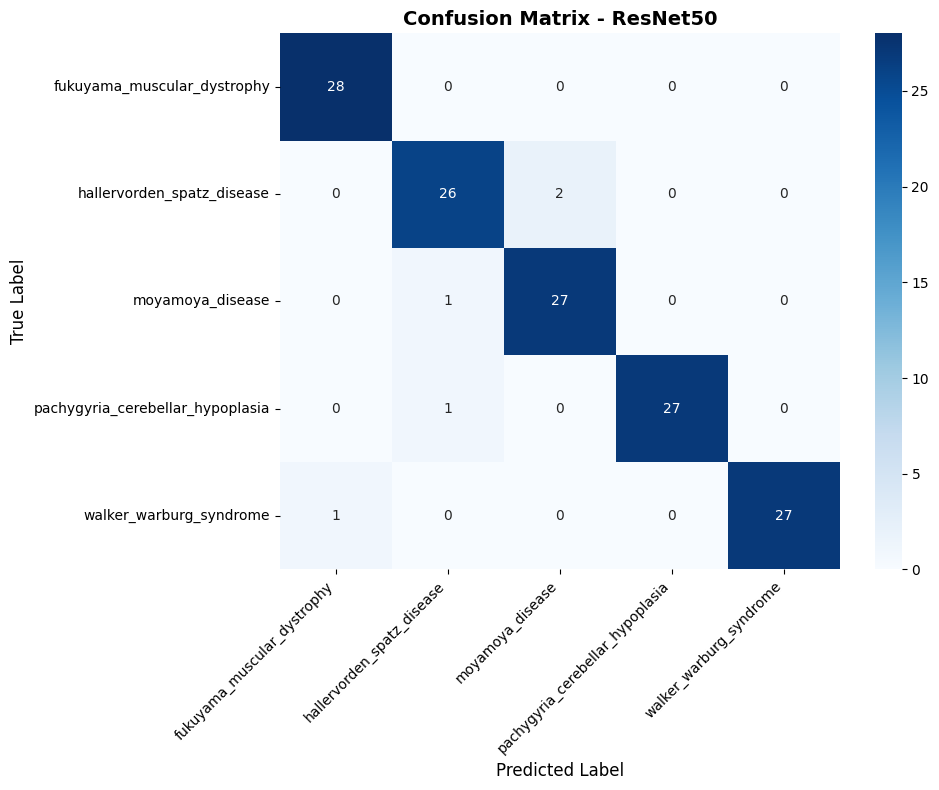

In [9]:

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - ResNet50', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('resnet50_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

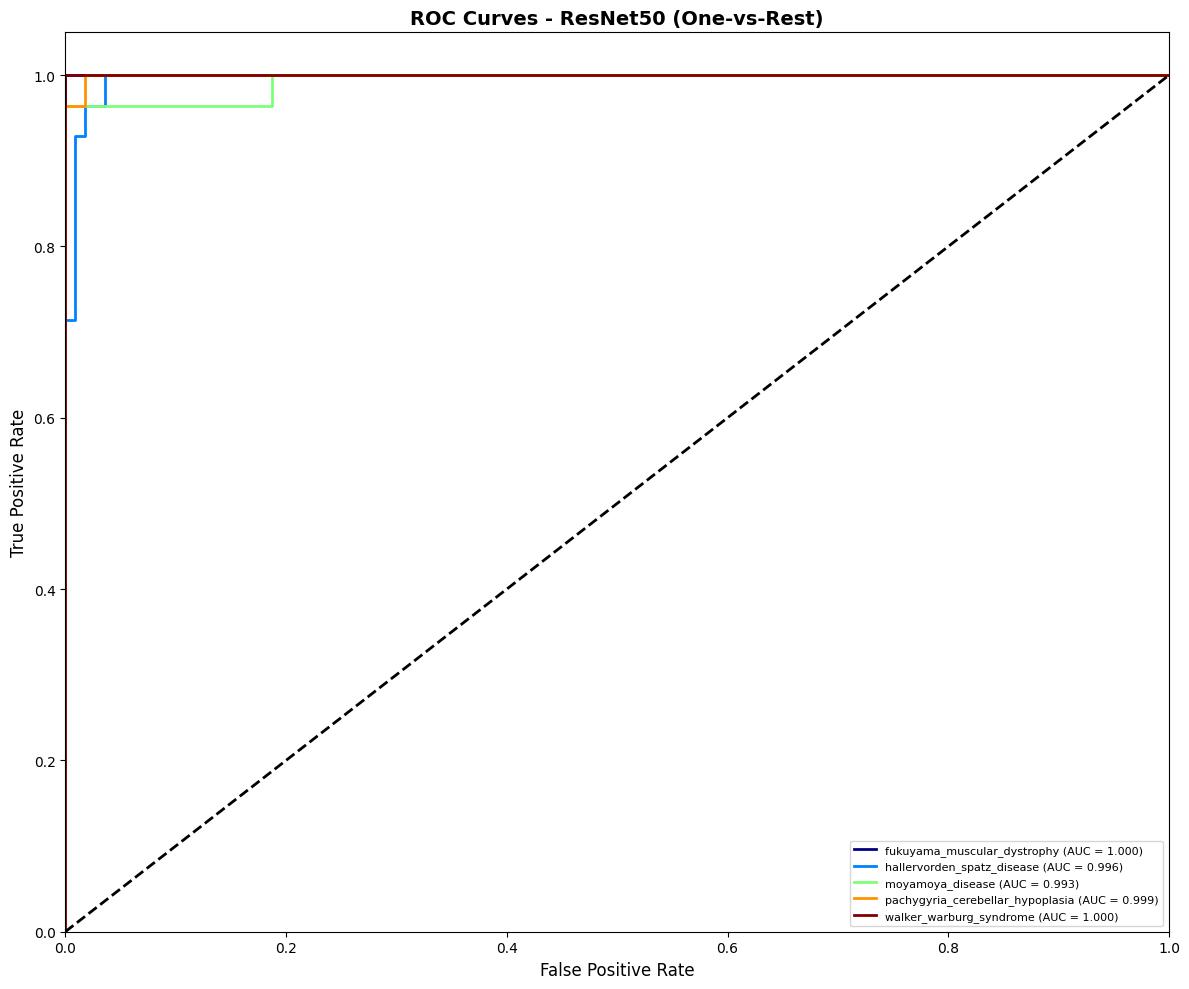

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import label_binarize
y_true_bin = label_binarize(true_classes, classes=list(range(num_classes)))
y_score = predictions

plt.figure(figsize=(12, 10))
colors = plt.cm.jet(np.linspace(0, 1, num_classes))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - ResNet50 (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig('resnet50_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

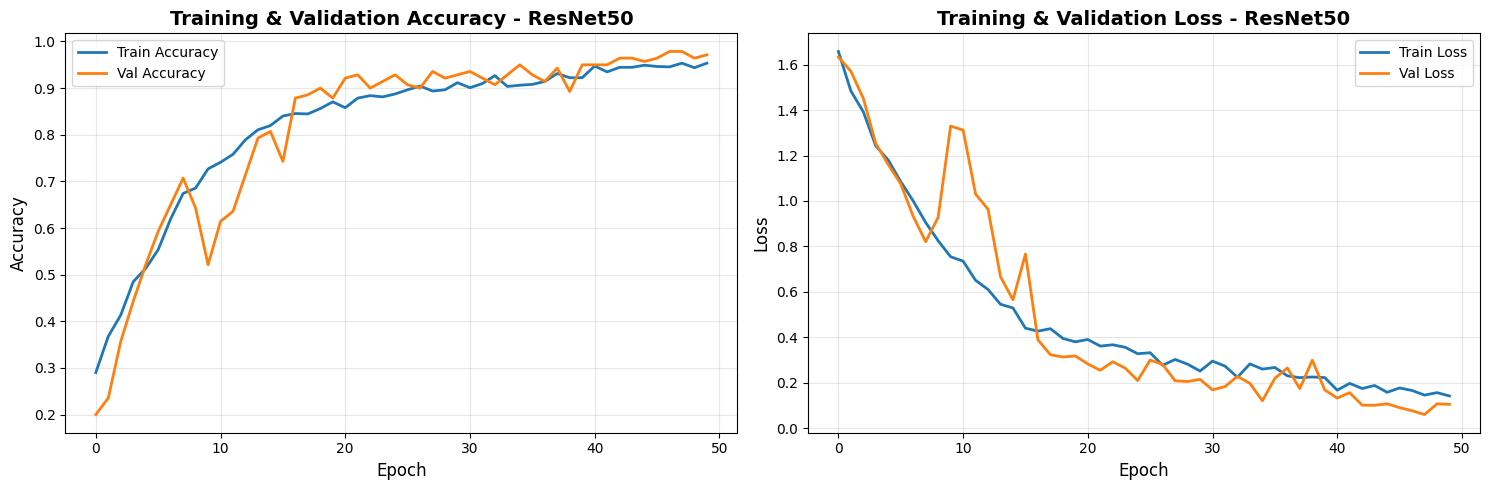

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training & Validation Accuracy - ResNet50', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training & Validation Loss - ResNet50', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resnet50_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
model.save('resnet50.h5')
print("\nModel saved as 'resnet50.h5'")
print("Best model weights saved as 'best_resnet50_tf_model.h5'")


Model saved as 'resnet50.h5'
Best model weights saved as 'best_resnet50_tf_model.h5'
